In [20]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import warnings
warnings.filterwarnings('ignore')

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [2]:
DATA_DIR = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"

In [5]:
genres = os.listdir(DATA_DIR)
print(f"Found {len(genres)} genres: {genres}")

Found 10 genres: ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


In [6]:
def wav_to_spectrogram(file_path, size=128):
    y, sr = librosa.load(file_path, sr=22050)
    spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    if spec_db.shape[1] > size:
        spec_db = spec_db[:, :size]
    else:
        spec_db = np.pad(spec_db, ((0,0), (0, size - spec_db.shape[1])), 'constant')
    return spec_db

In [7]:
def extract_mfcc(file_path, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

In [14]:
X_spectrogram = []
X_mfcc = []
y_labels = []

for genre in genres:
    genre_path = os.path.join(DATA_DIR, genre)
    files = [f for f in os.listdir(genre_path) if f.endswith(".wav")]
    first_file_path = os.path.join(genre_path, files[0])

    for file in files:
        full_path = os.path.join(genre_path, file)
        try:
            X_spectrogram.append(wav_to_spectrogram(full_path))
            X_mfcc.append(extract_mfcc(full_path))
            y_labels.append(genre)
        except:
            print(f"Corrupted file skipped & replaced: {full_path}")
            X_spectrogram.append(wav_to_spectrogram(first_file_path))
            X_mfcc.append(extract_mfcc(first_file_path))
            y_labels.append(genre)

X_spectrogram = np.array(X_spectrogram)[..., np.newaxis]
X_mfcc = np.array(X_mfcc)
y_labels = np.array(y_labels)

Corrupted file skipped & replaced: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav


In [15]:
X_spectrogram.shape, X_mfcc.shape

((1000, 128, 128, 1), (1000, 40))

In [16]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)
y_categorical = to_categorical(y_encoded)

# Split for CNN (image-based)
X_spec_train, X_spec_test, y_train, y_test = train_test_split(
    X_spectrogram, y_categorical, test_size=0.2, stratify=y_labels, random_state=42)

# Split for Random Forest (tabular)
X_mfcc_train, X_mfcc_test, y_train_rf, y_test_rf = train_test_split(
    X_mfcc, y_encoded, test_size=0.2, stratify=y_labels, random_state=42)

In [17]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rf_model.fit(X_mfcc_train, y_train_rf)
rf_pred = rf_model.predict(X_mfcc_test)
rf_accuracy = accuracy_score(y_test_rf, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy*100:.2f}%")

Random Forest Accuracy: 59.50%


In [18]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    BatchNormalization(), MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(), MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(), MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_spec_train, y_train, epochs=40, batch_size=32,
              validation_data=(X_spec_test, y_test), verbose=1)
cnn_accuracy = cnn_model.evaluate(X_spec_test, y_test, verbose=0)[1]
print(f"CNN Accuracy: {cnn_accuracy*100:.2f}%")

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.1636 - loss: 15.7413 - val_accuracy: 0.1500 - val_loss: 81.7990
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.3013 - loss: 3.2398 - val_accuracy: 0.1000 - val_loss: 19.5633
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3326 - loss: 2.1019 - val_accuracy: 0.1300 - val_loss: 9.6662
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3848 - loss: 1.7729 - val_accuracy: 0.1550 - val_loss: 4.0031
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3930 - loss: 1.6306 - val_accuracy: 0.2050 - val_loss: 2.5103
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4453 - loss: 1.5674 - val_accuracy: 0.2250 - val_loss: 2.2945
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4819 - loss: 1.4296 - val_accuracy: 0.3650 - val_loss: 2.1215
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5009 - loss: 1.4148 - val_accuracy: 0.3200 - val_lo

In [19]:
X_rgb = np.repeat(X_spectrogram, 3, axis=-1)
X_train_rgb, X_test_rgb, _, _ = train_test_split(X_rgb, y_categorical, test_size=0.2,
                                                 stratify=y_labels, random_state=42)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False

tl_model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
tl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tl_model.fit(X_train_rgb, y_train, epochs=15, batch_size=32,
             validation_data=(X_test_rgb, y_test), verbose=1)

tl_accuracy = tl_model.evaluate(X_test_rgb, y_test, verbose=0)[1]
print(f"ResNet50 Transfer Learning Accuracy: {tl_accuracy*100:.2f}%")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.2468 - loss: 11.0720 - val_accuracy: 0.4250 - val_loss: 2.2564
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5085 - loss: 1.6958 - val_accuracy: 0.4900 - val_loss: 1.4426
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.6379 - loss: 1.1592 - val_accuracy: 0.5650 - val_loss: 1.2570
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.6979 - loss: 0.8352 - val_accuracy: 0.5750 - val_loss: 1.2483
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.7353 - loss: 0.7631 - val_accuracy: 0.5950 - val_loss: 1.1954
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.7933 - loss: 0.5484 - val_accuracy: 0.5950 - val_loss: 1.1427
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8325 - loss: 0.4896 - val_accuracy: 0.5850 - val_loss: 1.3628
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.85

In [22]:
results_df = pd.DataFrame({
    "Approach": ["Random Forest (MFCCs)", "CNN", "ResNet50 Transfer Learning"],
    "Accuracy": [f"{rf_accuracy*100:.2f}%", f"{cnn_accuracy*100:.2f}%", f"{tl_accuracy*100:.2f}%"]
})
print("Final Results Comparison:")
print(results_df.to_string(index=False))

Final Results Comparison:
                  Approach Accuracy
     Random Forest (MFCCs)   59.50%
                       CNN   51.50%
ResNet50 Transfer Learning   66.50%


7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


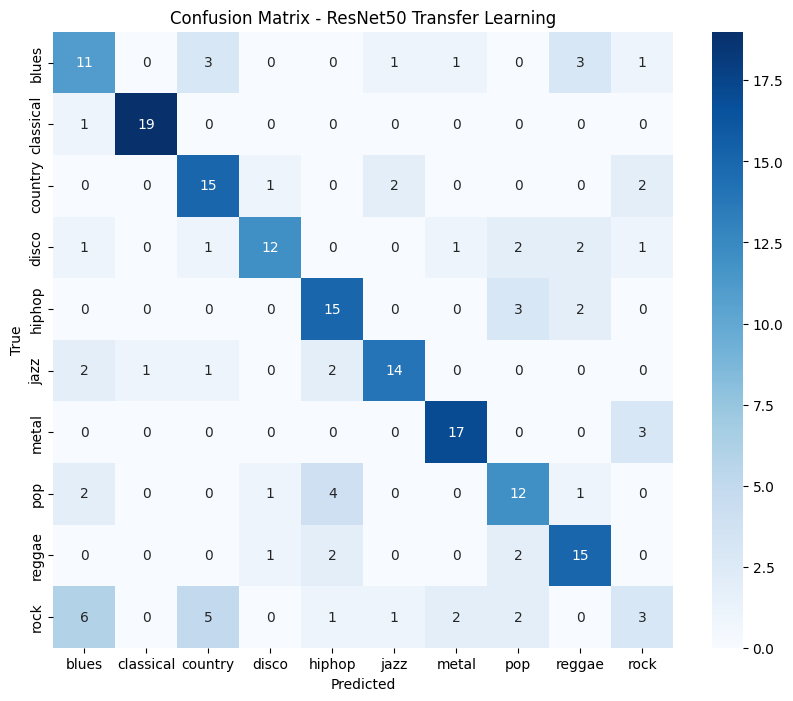

In [23]:
y_pred_tl = np.argmax(tl_model.predict(X_test_rgb), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_tl)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - ResNet50 Transfer Learning')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()